## Importing Libraries

In [1]:
import time, requests, datetime as dt
import numpy as np, pandas as pd, seaborn as sns, matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from scipy.stats import spearmanr
import torch
import os


# CONFIG
LOOKBACK_D = 7 # news window
FWD_DAYS = 5 # forward return horizon
PANEL_DAYS = 10 # length of panel
NEWS_TOP_N = 5 # more headlines = smoother score
ALPHA_KEY = os.environ["AV_KEY"]
NEWS_KEY = os.environ["NEWS_KEY"]


# company list
ticker_to_name = {
    "TSLA": "Tesla",
    "F": "Ford",
    "GM": "GM",
    "RIVN": "Rivian",
    "LCID": "Lucid",
    "TM": "Toyota",
    "HMC": "Honda",
    "NIO": "NIO",
    "XPEV": "XPeng",
    "STLA": "Stellantis",
    "PSNY": "Polestar",
    "LI": "Li Auto",
    "RACE": "Ferrari",
    "LCII": "LCI Industries",
    "ALV": "Autoliv"
}


## Getting new data

In [2]:
# Headline fetching for a specific date range
def alpha_news_window(ticker, from_dt, to_dt, limit=NEWS_TOP_N):
    url = "https://www.alphavantage.co/query"
    params = {
        "function": "NEWS_SENTIMENT",
        "tickers": ticker,
        "time_from": from_dt.strftime("%Y%m%dT%H%M"),
        "time_to": to_dt.strftime("%Y%m%dT%H%M"),
        "sort": "LATEST",
        "apikey": ALPHA_KEY,
    }
    r = requests.get(url, params=params, timeout=10)
    if r.status_code == 503:
        raise RuntimeError("Alpha Vantage news quota exhausted.")
    r.raise_for_status()
    feed = r.json().get("feed", [])
    return [item["title"] for item in feed[:limit]]


# Alpha-vantage fwd return from a given anchor date
def alpha_fwd_return(ticker, anchor_date, days=5):
    url = "https://www.alphavantage.co/query"
    params = {"function": "TIME_SERIES_DAILY_ADJUSTED",
              "symbol": ticker, "apikey": ALPHA_KEY, "outputsize": "compact"}
    data = requests.get(url, params=params, timeout=10).json().get("Time Series (Daily)", {})
    if not data or anchor_date.isoformat() not in data:
        return np.nan
    ordered = sorted(data.keys())  # oldest->newest
    idx_a = ordered.index(anchor_date.isoformat())
    idx_b = idx_a + days
    if idx_b >= len(ordered):
        return np.nan
    p0 = float(data[ordered[idx_a]]["5. adjusted close"])
    p1 = float(data[ordered[idx_b]]["5. adjusted close"])
    return (p1 - p0) / p0 * 100
    


## Loading the FinBert Model

In [3]:
tokenizer = AutoTokenizer.from_pretrained("yiyanghkust/finbert-tone")
model = AutoModelForSequenceClassification.from_pretrained("yiyanghkust/finbert-tone")
model.eval()


labels = ["negative", "neutral", "positive"]
label_to_score = {"negative": -1, "neutral": 0, "positive": 1}


C:\Users\bhall\anaconda3\envs\pytorch_env_new\lib\site-packages\huggingface_hub\file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


## Sentiment Classification

In [4]:
def classify_sentiment(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512)
    with torch.no_grad():
        out = model(**inputs)
    probs = torch.nn.functional.softmax(out.logits, dim=1).numpy()[0]
    idx = np.argmax(probs)
    return {"score": label_to_score[labels[idx]], "conf": probs[idx]}
    


## Agent 2 Function

TSLA: ✓
F: ✓
GM: ✓
RIVN: ✓
LCID: ✓
TM: ✓
HMC: ✓
NIO: ✓
XPEV: ✓
STLA: ✓
PSNY: ✓
LI: ✓
RACE: ✓
LCII: ✓
ALV: ✓

Panel size: 88
Spearman ρ = -0.098  (p = 0.36160)


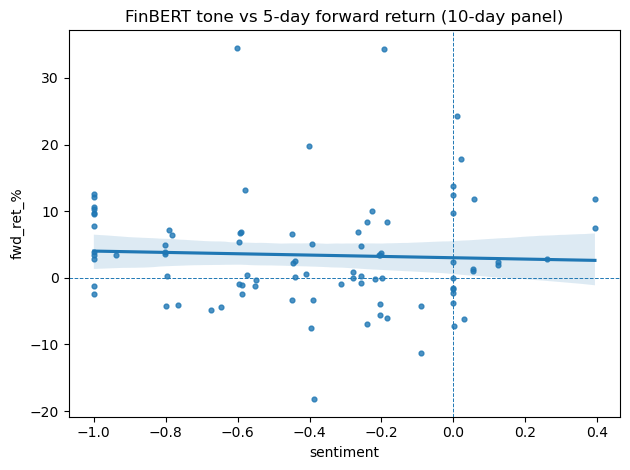

In [5]:
# build panel
today = dt.date.today()
trade_days = pd.bdate_range(end=today - dt.timedelta(days=FWD_DAYS),
                            periods=PANEL_DAYS)


panel = []
for tkr, cname in ticker_to_name.items():
    print(f"{tkr}: ", end="", flush=True)
    for anchor in trade_days:
        news_from = (anchor - dt.timedelta(days=LOOKBACK_D)).date()
        headlines = alpha_news_window(tkr, news_from, anchor.date(), limit=NEWS_TOP_N)
        if not headlines:
            continue
        scores, confs = [], []
        for h in headlines:
            

            res = classify_sentiment(h)
            scores.append(res["score"])
            confs.append(res["conf"])
        s_score = float(np.average(scores, weights=np.square(confs)))
        fwd_ret = alpha_fwd_return(tkr, anchor.date(), FWD_DAYS)
        if np.isnan(fwd_ret):
            continue
        panel.append([anchor.date(), tkr, s_score, fwd_ret, np.mean(confs)])
        time.sleep(0.15)
    print("✓")


panel_df = pd.DataFrame(
        panel,
        columns=["date", "ticker", "sentiment", "fwd_ret_%", "mean_conf"]
)
print(f"\nPanel size: {len(panel_df)}")


# correlation & plot
rho, p = spearmanr(panel_df["sentiment"], panel_df["fwd_ret_%"])
print(f"Spearman ρ = {rho:.3f}  (p = {p:.5f})")


sns.regplot(data=panel_df, x="sentiment", y="fwd_ret_%", scatter_kws={"s":12})
plt.axhline(0, ls="--", lw=0.7); plt.axvline(0, ls="--", lw=0.7)
plt.title(f"FinBERT tone vs 5-day forward return ({PANEL_DAYS}-day panel)")
plt.tight_layout(); plt.show()


## Saving Data for evals

In [9]:
# Saving panel to disk
import os, datetime as dt, pathlib, pandas as pd


SAVE_DIR = pathlib.Path("panel_runs")
SAVE_DIR.mkdir(exist_ok=True)


stamp = dt.date.today().strftime("%Y-%m-%d")
fname = SAVE_DIR / f"panel_{stamp}.csv"


panel_df.to_csv(fname, index=False)
print(f"Saved {len(panel_df)} rows to {fname}")


Saved 89 rows to panel_runs\panel_2025-07-30.csv


## Loading data for evals

In [12]:
import pandas as pd
panel_df = pd.read_csv("panel_runs/panel_2025-07-30.csv")


print(panel_df.head())


         date ticker  sentiment  fwd_ret_%  mean_conf  abs_sent
0  2025-07-14   TSLA  -0.199868   3.657305   0.999908  0.199868
1  2025-07-15   TSLA  -0.266363   6.863376   0.884590  0.266363
2  2025-07-16   TSLA  -0.206835   3.385457   0.980118  0.206835
3  2025-07-17   TSLA  -0.645730  -4.417520   0.938030  0.645730
4  2025-07-18   TSLA  -0.766237  -4.122554   0.911903  0.766237


## Evaluations

## Bucketed Bar Chart

C:\Users\bhall\AppData\Local\Temp\ipykernel_30300\494988352.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["bucket", "direction_align"])


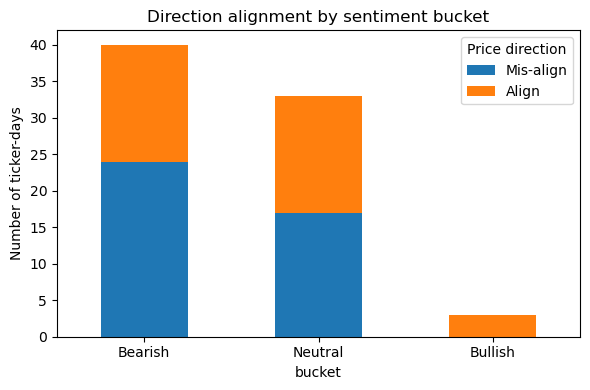

In [6]:
import seaborn as sns, matplotlib.pyplot as plt, pandas as pd, numpy as np


bins = [-1.0, -0.25, 0.25, 1.0]
labels = ["Bearish", "Neutral", "Bullish"]
panel_df["bucket"] = pd.cut(panel_df["sentiment"], bins=bins, labels=labels)


panel_df["direction_align"] = (
    (panel_df.sentiment >  0) & (panel_df["fwd_ret_%"] > 0) |
    (panel_df.sentiment <  0) & (panel_df["fwd_ret_%"] < 0)
)


pivot = (panel_df
         .groupby(["bucket", "direction_align"])
         .size()
         .unstack(fill_value=0))


pivot.plot(kind="bar", stacked=True, figsize=(6,4))
plt.title("Direction alignment by sentiment bucket")
plt.ylabel("Number of ticker-days")
plt.xticks(rotation=0)
plt.legend(labels=["Mis-align","Align"], title="Price direction")
plt.tight_layout(); plt.show()


## Confidence vs Magnitude

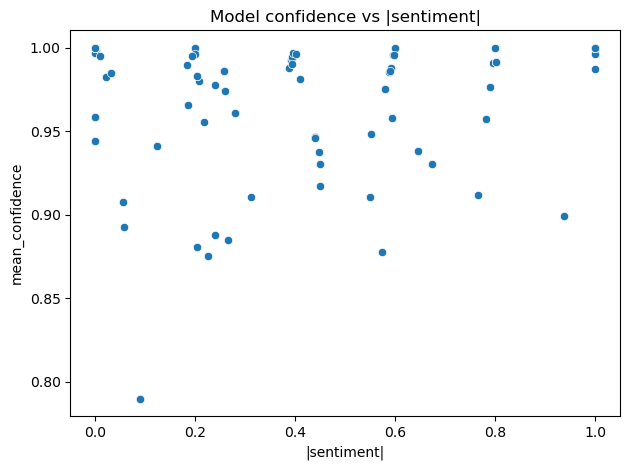

In [7]:
panel.append([anchor.date(), tkr, s_score, fwd_ret, np.mean(confs)])

panel_df = pd.DataFrame(panel, columns=["date","ticker","sentiment","fwd_ret_%","mean_conf"])


panel_df["abs_sent"] = panel_df["sentiment"].abs()
sns.scatterplot(data=panel_df, x="abs_sent", y="mean_conf")
plt.title("Model confidence vs |sentiment|")
plt.xlabel("|sentiment|"); plt.ylabel("mean_confidence")
plt.tight_layout(); plt.show()


In [8]:
cross = (panel_df
         .groupby("ticker")
         .agg(sentiment_score = ("sentiment", "mean"),
              fwd_ret_mean = ("fwd_ret_%", "mean"))
         .reset_index())


cross["direction_align"] = (
    (cross.sentiment_score >  0) & (cross.fwd_ret_mean > 0) |
    (cross.sentiment_score <  0) & (cross.fwd_ret_mean < 0)
)



for _, row in cross.iterrows():
    verdict = "Align" if row.direction_align else "Mis-align"
    print(f"{row.ticker:5s}  sentiment {row.sentiment_score:+.3f}  "
          f"avg 5-day return {row.fwd_ret_mean:+.2f}%  {verdict}")


rho, p = spearmanr(cross.sentiment_score, cross.fwd_ret_mean)
print(f"\nSpearman ρ (ticker cross-section) = {rho:.3f}  (p = {p:.3f})")


ALV    sentiment -0.261   avg 5-day return +0.23%   ❌ mis-align
F      sentiment -0.231   avg 5-day return -0.62%   ✅ align
GM     sentiment -0.319   avg 5-day return -0.26%   ✅ align
HMC    sentiment -1.000   avg 5-day return +6.76%   ❌ mis-align
LCID   sentiment -0.395   avg 5-day return +9.38%   ❌ mis-align
LI     sentiment -0.315   avg 5-day return -1.65%   ✅ align
NIO    sentiment -0.477   avg 5-day return +9.81%   ❌ mis-align
RACE   sentiment -0.330   avg 5-day return +2.07%   ❌ mis-align
RIVN   sentiment -0.262   avg 5-day return +4.98%   ❌ mis-align
STLA   sentiment -0.242   avg 5-day return +1.18%   ❌ mis-align
TM     sentiment -0.137   avg 5-day return +7.88%   ❌ mis-align
TSLA   sentiment -0.439   avg 5-day return +0.17%   ❌ mis-align
XPEV   sentiment -0.703   avg 5-day return +3.38%   ❌ mis-align

Spearman ρ (ticker cross-section) = -0.335   (p = 0.263)
